In [45]:
!pip install h2o

In [46]:
# Dataset provided by PhD (c) Daniela Turis, IFA-UV.
import sys
# Verifica si estás en Google Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # En Colab, usamos gdown
    import gdown
    !gdown https://drive.google.com/uc?id=14NHeV1fvE2HXMaghHAszf_92iTBVNJHL
    !gdown  https://drive.google.com/uc?id=1g56JSd46v1HjJkhpIw7Qkal--VDd7cpS
    !gdown  https://drive.google.com/uc?id=1YA9HYeOKHMYvt9M4LAaLkO8mpJjOXktV

    data = np.load("subset_vmic10.npy")
    y = np.load("y_subset_vmic10.npy")

else:
    # En entorno local, carga desde disco
    dir_path = "/Users/rpezoa/experiment_data/data_fo/data_vmic10/"
    if os.path.exists(dir_path):
        print("Archivo cargado localmente:", dir_path + "subset_vmic10.npy")
        data = np.load(dir_path + "subset_vmic10.npy")
        y = np.load(dir_path + "y_subset_vmic10.npy")
        data_observed = np.load("/Users/rpezoa/experiment_data/data_fo/data/X_observed.npy")

    else:
        print("No se encontró el archivo local. Debes descargarlo manualmente.")


#problema de regresion


Downloading...
From: https://drive.google.com/uc?id=14NHeV1fvE2HXMaghHAszf_92iTBVNJHL
To: /content/subset_vmic10.npy
100% 16.0M/16.0M [00:00<00:00, 36.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1g56JSd46v1HjJkhpIw7Qkal--VDd7cpS
To: /content/y_subset_vmic10.npy
100% 720k/720k [00:00<00:00, 32.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1YA9HYeOKHMYvt9M4LAaLkO8mpJjOXktV
To: /content/X_observed.npy
100% 973k/973k [00:00<00:00, 36.9MB/s]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 73s 295ms/step - loss: 0.5935 - mae: 0.5153 - val_loss: 0.0574 - val_mae: 0.1991 - learning_rate: 0.0010
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 77s 273ms/step - loss: 0.0551 - mae: 0.1767 - val_loss: 0.0682 - val_mae: 0.2156 - learning_rate: 0.0010
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 79s 258ms/step - loss: 0.0283 - mae: 0.1285 - val_loss: 0.0253 - val_mae: 0.1160 - learning_rate: 0.0010
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 83s 261ms/step - loss: 0.0204 - mae: 0.1095 - val_loss: 0.0099 - val_mae: 0.0739 - learning_rate: 0.0010
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 90s 300ms/step - loss: 0.0164 - mae: 0.0983 - val_loss: 0.0096 - val_mae: 0.0750 - learning_rate: 0.0010
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 75s 267ms/step - loss: 0.0133 - mae: 0.0880 - val_loss: 0.0077 - val_mae: 0.0628 - learning_rate: 0.0010
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 53s 267ms/step - loss: 0.0122 - mae: 0.0838 - val_loss: 0.0073 - val_mae: 0.0639 - learnin

Test MSE: 0.0032
Test MAE: 0.0417


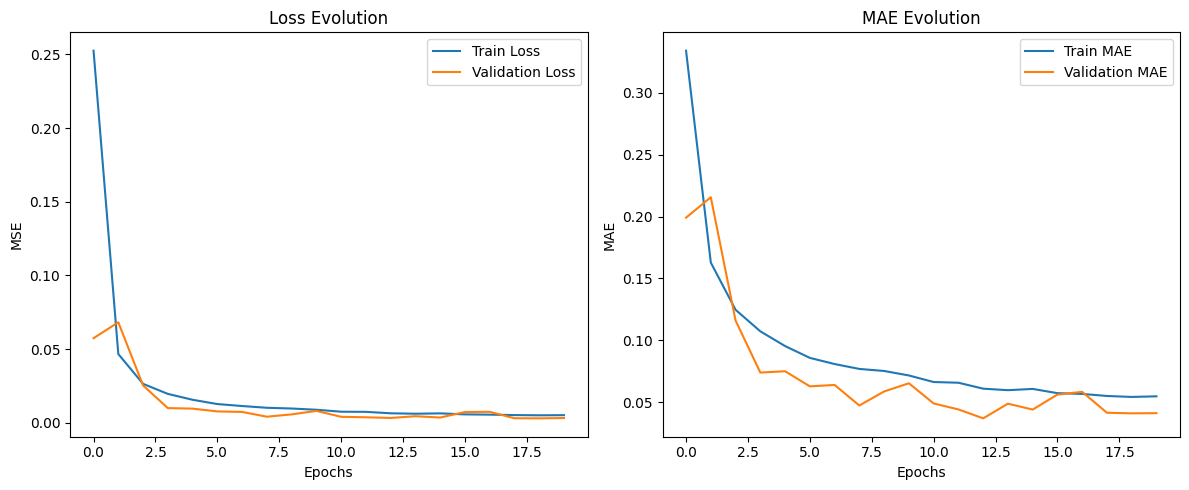

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step


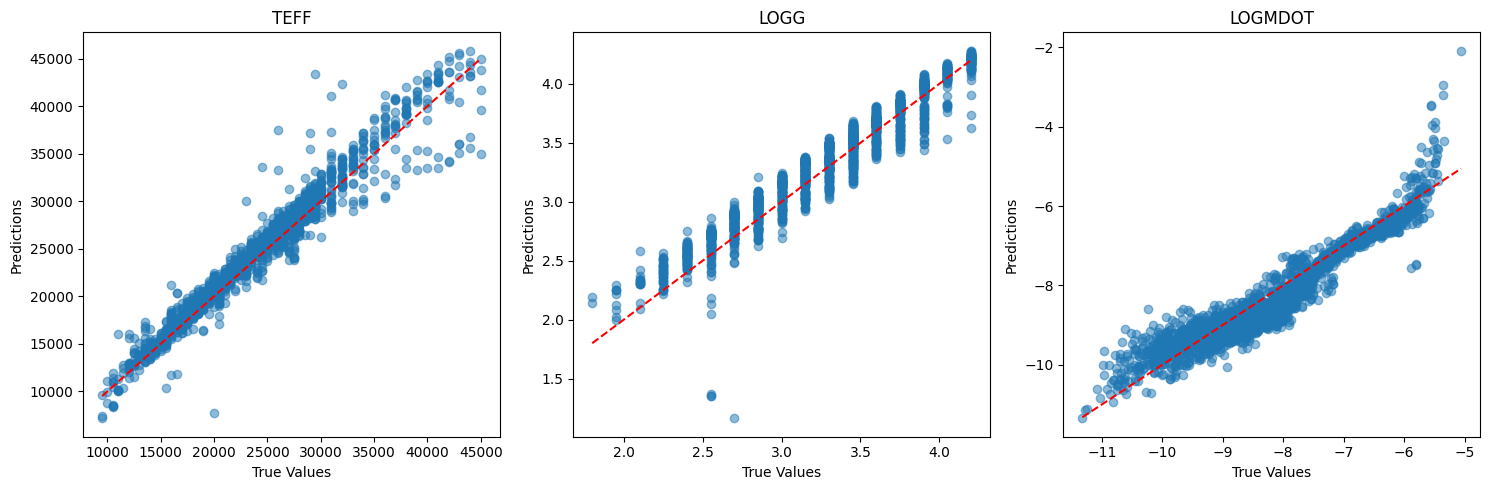

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load and prepare data
data = np.load("subset_vmic10.npy")
y = np.load("y_subset_vmic10.npy")
y_selected = y[:, [0, 1, 7]]  # TEFF, LOGG, LOGMDOT

# Normalize features and targets
scaler_X = StandardScaler()
X_normalized = scaler_X.fit_transform(data)

scaler_y = MinMaxScaler()
y_normalized = scaler_y.fit_transform(y_selected)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_normalized, y_normalized, test_size=0.2, random_state=42
)

# Reshape for CNN 1D [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build the model with proper dimensionality
model = Sequential()
model.add(InputLayer(input_shape=(X_train.shape[1], 1)))  # Using InputLayer instead of Input

# First block - larger kernel size
model.add(Conv1D(filters=64, kernel_size=25, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())

# Second block
model.add(Conv1D(filters=128, kernel_size=15, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())

# Third block
model.add(Conv1D(filters=256, kernel_size=10, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())

# Fourth block - no pooling to preserve dimensions
model.add(Conv1D(filters=256, kernel_size=5, activation='relu', padding='same'))
model.add(BatchNormalization())

# Flatten the output
model.add(Flatten())

# Dense layers
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())

# Output layer for 3 targets
model.add(Dense(3, activation='linear'))

# Compile
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Callbacks
callbacks = [
    EarlyStopping(patience=20, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=10)
]

# Train
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# === Guardar el modelo entrenado ===
model.save("cnn_vmic_model.h5")


# Evaluate
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test MSE: {loss:.4f}")
print(f"Test MAE: {mae:.4f}")

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Evolution')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE Evolution')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()

# Make predictions
predictions = model.predict(X_test)

# Inverse transform predictions and test values
predictions_denorm = scaler_y.inverse_transform(predictions)
y_test_denorm = scaler_y.inverse_transform(y_test)

# Plot results for each target
target_names = ['TEFF', 'LOGG', 'LOGMDOT']
plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.scatter(y_test_denorm[:, i], predictions_denorm[:, i], alpha=0.5)
    plt.plot([min(y_test_denorm[:, i]), max(y_test_denorm[:, i])],
             [min(y_test_denorm[:, i]), max(y_test_denorm[:, i])], 'r--')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title(target_names[i])
plt.tight_layout()
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [25]:
print(predictions[1])
print(loss)


# Crear el DataFrame con las predicciones
df_predicciones = pd.DataFrame(y_test_denorm)
df_predicciones.index.name = "ID_espectro"

# Opcional: agregar nombres de columnas si los conoces
df_predicciones.columns = ["Teff", "Logg", "PerdMasa"]
df_predicciones

[0.39254904 0.71528095 0.29382873]
0.003833744442090392


,Teff,Logg,PerdMasa
ID_espectro,,,
0,24000.0,3.60,-9.123363
1,22500.0,3.45,-9.427414
2,38000.0,3.75,-7.290912
3,16500.0,2.85,-8.908279
4,26000.0,3.15,-9.032515
...,...,...,...
1995,22000.0,2.85,-8.761184
1996,26000.0,3.45,-8.622178
1997,41000.0,3.75,-6.096481


In [24]:
print(predictions)

[[0.4463871  0.8199321  0.3558739 ]
 [0.39254904 0.71528095 0.29382873]
 [0.83892846 0.8581014  0.5678183 ]
 ...
 [0.69338053 0.8105121  0.7810282 ]
 [0.09781842 0.34709752 0.41616875]
 [0.5616625  0.7346957  0.7246505 ]]


In [16]:
from sklearn.metrics import mean_squared_error, confusion_matrix
import seaborn as sns
import numpy as np

# Calcular MSE para cada variable
mse_teff = mean_squared_error(y_test_denorm[:, 0], predictions_denorm[:, 0])
mse_logg = mean_squared_error(y_test_denorm[:, 1], predictions_denorm[:, 1])
mse_logmdot = mean_squared_error(y_test_denorm[:, 2], predictions_denorm[:, 2])

print(f'MSE para TEFF: {mse_teff:.4f}')
print(f'MSE para LOGG: {mse_logg:.4f}')
print(f'MSE para LOGMDOT: {mse_logmdot:.4f}')




MSE para TEFF: 5147378.8843
MSE para LOGG: 0.0183
MSE para LOGMDOT: 0.1892


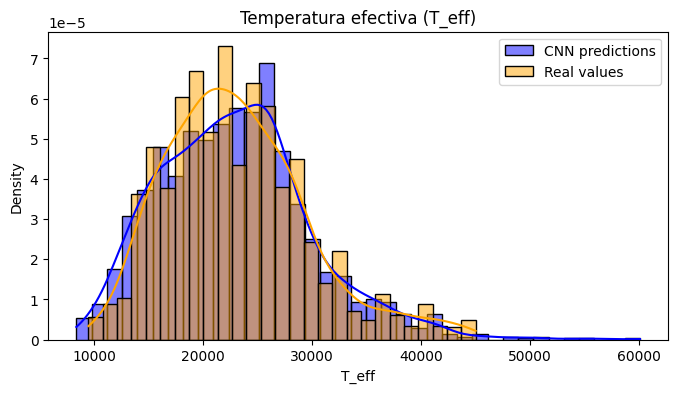

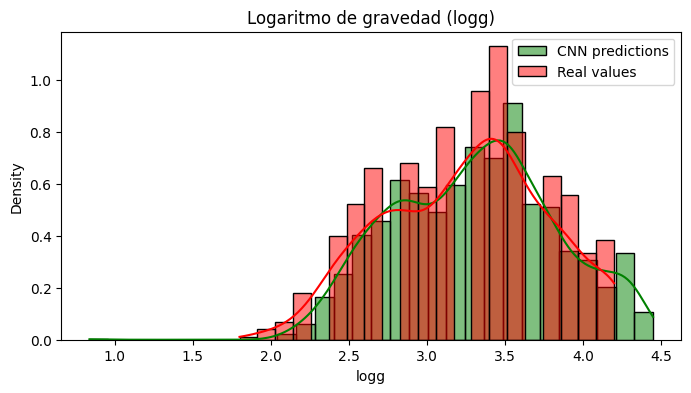

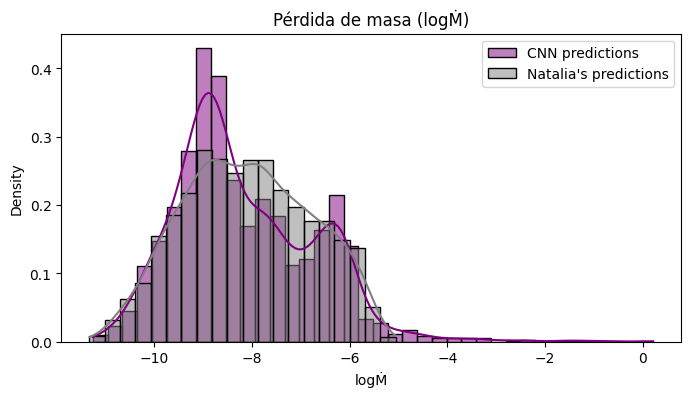

In [28]:
# Create a DataFrame for easier plotting
cnn_teff= predictions_denorm[:, 0]
cnn_logg = predictions_denorm[:, 1]
cnn_logmdot = predictions_denorm[:, 2]

T_eff = y_test_denorm[:, 0]
logg = y_test_denorm[:, 1]
logmdot = y_test_denorm[:, 2]


df = pd.DataFrame({
    "T_eff_CNN": cnn_teff,
    "T_eff_natalia": T_eff,
    "logg_CNN": cnn_logg,
    "logg_natalia": logg,
    "logmdot_CNN": cnn_logmdot,
    "logmdot_natalia": logmdot
})

# Plot T_eff
plt.figure(figsize=(8, 4))
sns.histplot(df["T_eff_CNN"], color="blue", label="CNN predictions", kde=True, stat="density", alpha=0.5)
sns.histplot(df["T_eff_natalia"], color="orange", label="Real values", kde=True, stat="density", alpha=0.5)
plt.title("Temperatura efectiva (T_eff)")
plt.xlabel("T_eff")
plt.legend()
plt.show()

# Plot logg
plt.figure(figsize=(8, 4))
sns.histplot(df["logg_CNN"], color="green", label="CNN predictions", kde=True, stat="density", alpha=0.5)
sns.histplot(df["logg_natalia"], color="red", label="Real values", kde=True, stat="density", alpha=0.5)
plt.title("Logaritmo de gravedad (logg)")
plt.xlabel("logg")
plt.legend()
plt.show()

# Plot logmdot
plt.figure(figsize=(8, 4))
sns.histplot(df["logmdot_CNN"], color="purple", label="CNN predictions", kde=True, stat="density", alpha=0.5)
sns.histplot(df["logmdot_natalia"], color="gray", label="Natalia's predictions", kde=True, stat="density", alpha=0.5)
plt.title("Pérdida de masa (logṀ)")
plt.xlabel("logṀ")
plt.legend()
plt.show()

In [39]:
from scipy import stats

# Prueba KS para T_eff
ks_teff = stats.ks_2samp(df["T_eff_CNN"], df["T_eff_natalia"])
print(f"KS para T_eff: Estadístico = {ks_teff.statistic:.4f}, p-value = {ks_teff.pvalue:.4f}")

# Prueba KS para logg
ks_logg = stats.ks_2samp(df["logg_CNN"], df["logg_natalia"])
print(f"KS para logg: Estadístico = {ks_logg.statistic:.4f}, p-value = {ks_logg.pvalue:.4f}")

# Prueba KS para logmdot
ks_logmdot = stats.ks_2samp(df["logmdot_CNN"], df["logmdot_natalia"])
print(f"KS para logmdot: Estadístico = {ks_logmdot.statistic:.4f}, p-value = {ks_logmdot.pvalue:.4f}")

KS para T_eff: Estadístico = 0.0515, p-value = 0.0099
KS para logg: Estadístico = 0.1020, p-value = 0.0000
KS para logmdot: Estadístico = 0.0990, p-value = 0.0000


In [37]:

np.std(df["T_eff_natalia"])

6573.725042736424

In [38]:
np.std(df["T_eff_CNN"])

6932.56396484375

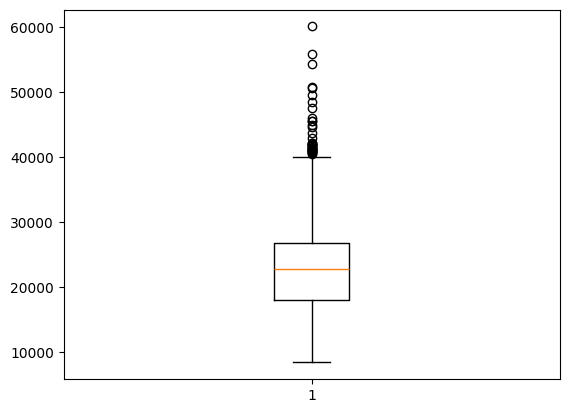

In [40]:
plt.boxplot(df["T_eff_CNN"])
plt.show()

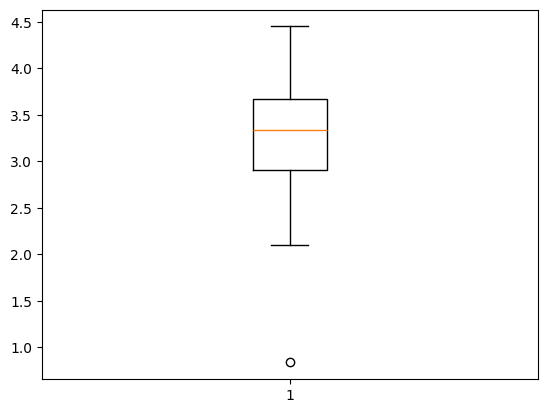

In [41]:
plt.boxplot(df["logg_CNN"])
plt.show()

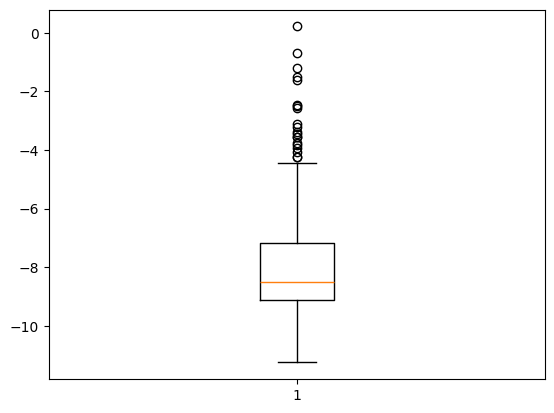

In [43]:
plt.boxplot(df["logmdot_CNN"])
plt.show()

In [44]:
print(f"Media T_eff (CNN): {df['T_eff_CNN'].mean():.2f} vs Real: {df['T_eff_natalia'].mean():.2f}")

Media T_eff (CNN): 22960.23 vs Real: 23103.75


In [48]:
# === Guardar los parámetros del StandardScaler (X) ===
np.save("scaler_X_mean.npy", scaler_X.mean_)
np.save("scaler_X_scale.npy", scaler_X.scale_)

# === Guardar los parámetros del MinMaxScaler (y) ===
np.save("scaler_y_min.npy", scaler_y.min_)
np.save("scaler_y_scale.npy", scaler_y.scale_)
